---
title: "Burrows-Wheeler Transform in Python"
execute: 
  enabled: false
  freeze: true
date: "11/6/2024"
categories: [Bioinformatics, BWT, data structure]
---


> Burrows-Wheeler Transform is a method used for pattern matching problem. We can use it to find all instances of substrings in the database that matches our query sequence.

I recently learnt about Burrows-Wheeler Transform from the <a href="https://www.youtube.com/playlist?list=PLM_KIlU0WoXmkV4QB1Dg8PtJaHTdWHwRS">Advanced Data Structure</a> playlist by Niema Moshiri. In this notebook, I tried to implement it using python.

In [ ]:
from collections import Counter
import pandas as pd

In [1]:
db = 'BANANA$'

# Extracting Burrow-Wheeler Transform (BWT)

In [23]:
rotations = []
rotations.append(db)
s = db
for i in range(len(db)-1):
    s = s[-1] + s[:-1]
    rotations.append(s)

In [28]:
pd.DataFrame({'rotations':rotations, 'sorted_rotations': sorted(rotations)})

,rotations,sorted_rotations
0,BANANA$,$BANANA
1,$BANANA,A$BANAN
2,A$BANAN,ANA$BAN
3,NA$BANA,ANANA$B
4,ANA$BAN,BANANA$
5,NANA$BA,NA$BANA
6,ANANA$B,NANA$BA


The Burrow - Wheeler Transform (BWT) is the last characters from the list of sorted rotations.

In [29]:
BWT = [s[-1] for s in sorted(rotations)]
BWT

['A', 'N', 'N', 'B', '$', 'A', 'A']

# Inverting the Burrow-Wheeler Transform (BWT)

Burrow-Wheeler transform is reversable. Here's how to construct the original string from BWT:

## Step 1: List out BWT as last column and sorted list of the original database as first column

In [111]:
df = pd.DataFrame({'first': sorted(db), 'last': BWT})
df

,first,last
0,$,A
1,A,N
2,A,N
3,A,B
4,B,$
5,N,A
6,N,A


## Step 2: Add the number of times we've seen the character at that point as subscript

In [40]:
### adding subscript for first column (sorted original database)

dbcounter = Counter(db)

sorted_db_subs = []
for c in sorted(db, reverse=True):
    sorted_db_subs.append(c + str(dbcounter[c]))
    dbcounter[c] = dbcounter[c] - 1

sorted_db_subs = sorted(sorted_db_subs)
sorted_db_subs

['$1', 'A1', 'A2', 'A3', 'B1', 'N1', 'N2']

In [54]:
### adding subscript for last column (BWT)

dbcounter = Counter(BWT)
print(dbcounter)

bwt_subs = []
for c in BWT[::-1]:
    bwt_subs.append(c + str(dbcounter[c]))
    dbcounter[c] = dbcounter[c] - 1

bwt_subs = bwt_subs[::-1]


Counter({'A': 3, 'N': 2, 'B': 1, '$': 1})


In [112]:
df['first_sub'] = sorted_db_subs
df['last_sub'] = bwt_subs

In [90]:
df

,first,last,first_sub,last_sub
0,$,A,$1,A1
1,A,N,A1,N1
2,A,N,A2,N2
3,A,B,A3,B1
4,B,$,B1,$1
5,N,A,N1,A2
6,N,A,N2,A3


## Step 3: Add last-to-first mapping

In [92]:
MAPPING = {k:v for k,v in zip(df['first_sub'].values, range(len(df)))}
MAPPING

{'$1': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'B1': 4, 'N1': 5, 'N2': 6}

In [113]:
df['L2F'] = df.apply(lambda row: MAPPING[row['last_sub']],axis=1)
df

,first,last,first_sub,last_sub,L2F
0,$,A,$1,A1,1
1,A,N,A1,N1,5
2,A,N,A2,N2,6
3,A,B,A3,B1,4
4,B,$,B1,$1,0
5,N,A,N1,A2,2
6,N,A,N2,A3,3


We can reconstruct our original database string from this preprocessed data. Here's how:

We can start with the null termination character we added, we know it is in the first row, `first_sub` column, so we retrieve that first.

Remember that as part of our preprocessing steps we do rotations of the original database string, and from that rotations we save the first column in `first_sub` and the last column in `last_sub`? So this tells us that `first_sub` and `last_sub` are connected: `last_sub` character comes before `first_sub` character. 


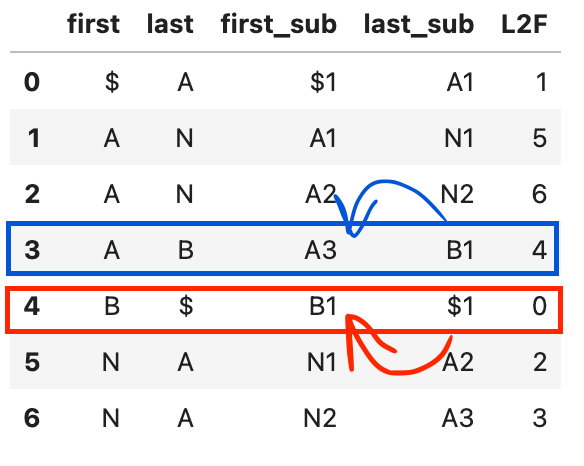


To illustrate:
1. Start with null termination `$1`.<br>
1. Find null termination `$1` in `last_sub` (row 4). The next character follows it is the corresponding character in `first_sub` column (red arrow). Now the reconstructed string is `$1 B1`.<br>
1. Find the last added character in the `last_sub`. Add its corresponding `first_sub` to the reconstructed string (blue arrow). Now the reconstructed string is `$1 B1 A3`.<br>
1. Continue building the reconstructed string until we reached the character `last_sub` of first row. Why first row? because we started the reconstructed string with `$1` -- which is also the `first_sub` character in our preprocessed data's first row.<br>

In [167]:
reconstruct = [df.loc[0,'first_sub']]

while reconstruct[-1] != df.loc[0,'last_sub']:
    last_char = reconstruct[-1]
    next_index = df[df['last_sub']==last_char].index.values[0]
    next_char = df.loc[df.index==next_index, 'first_sub'].values[0]
    reconstruct.append(next_char)

reconstructed_str_sub = ' '.join(reconstruct)
reconstructed_str = ''.join([c[0] for c in reconstruct])

print('Reconstructed database string (with subscript):',reconstructed_str_sub)
print('Reconstructed database string:', reconstructed_str)
print('Original database string:', db)

Reconstructed database string (with subscript): $1 B1 A3 N2 A2 N1 A1
Reconstructed database string: $BANANA
Original database string: BANANA$


We then move the null termination character to the end of the string and we can get back the original database.

# Pattern Matching using BWT

Let's try to do pattern matching using the preprocessed BWT from our toy database.

In [169]:
query = 'AN'

ok_range = range(len(df))
for c in query[::-1]:
    top = df.loc[df.index.isin(ok_range) & (df['last'] == c), 'L2F'].head(1).values[0]
    bottom = df.loc[df.index.isin(ok_range) & (df['last'] == c), 'L2F'].tail(1).values[0]
    ok_range = range(top, bottom+1)
    print('Found character:', c, '\n', df[df.index.isin(ok_range)])
    print('-'*40)

# exact match to query sequence is located between the top:bottom position of the preprocessed database
query_result = df.loc[df.index.isin(ok_range), 'first_sub'].values
print(f'Query "{query}" found in database sequence starting from:', query_result)
print('-'*40)

Found character: N 
   first last first_sub last_sub  L2F
5     N    A        N1       A2    2
6     N    A        N2       A3    3
----------------------------------------
Found character: A 
   first last first_sub last_sub  L2F
2     A    N        A2       N2    6
3     A    B        A3       B1    4
----------------------------------------
Query "AN" found in database sequence starting from: ['A2' 'A3']
----------------------------------------


The `query_result` does indeed match.
<br>
<br>- $1 B1 **A3 N2** A2 N1 A1
<br>- $1 B1 A3 N2 **A2 N1** A1

Let's make this into a function and try another example.

In [228]:
def reconstruct_db(df:pd.DataFrame) -> list:
    """Reconstruct database string using preprocessed data"""
    reconstruct = [df.loc[0,'first_sub']]

    while reconstruct[-1] != df.loc[0,'last_sub']:
        last_char = reconstruct[-1]
        next_index = df[df['last_sub']==last_char].index.values[0]
        next_char = df.loc[df.index==next_index, 'first_sub'].values[0]
        reconstruct.append(next_char)
    return reconstruct

def extract_bwt(db:str) -> list:
    """Extract Burrow-Wheeler Transform from database string"""
    rotations = []
    rotations.append(db)
    s = db
    for i in range(len(db)-1):
        s = s[-1] + s[:-1]
        rotations.append(s)

    BWT = [s[-1] for s in sorted(rotations)]
    return BWT

def preprocess_database(db:str) -> pd.DataFrame:
    """Preprocess data from database string"""
    BWT = extract_bwt(db)
    df = pd.DataFrame({'first': sorted(db), 'last': BWT})

    ### adding subscript for first column (sorted original database)
    dbcounter = Counter(db)    
    sorted_db_subs = []
    for c in sorted(db, reverse=True):
        sorted_db_subs.append(c + str(dbcounter[c]))
        dbcounter[c] = dbcounter[c] - 1
    sorted_db_subs = sorted(sorted_db_subs)

    ### adding subscript for last column (BWT)
    dbcounter = Counter(BWT)
    bwt_subs = []
    for c in BWT[::-1]:
        bwt_subs.append(c + str(dbcounter[c]))
        dbcounter[c] = dbcounter[c] - 1
    bwt_subs = bwt_subs[::-1]

    df['first_sub'] = sorted_db_subs
    df['last_sub'] = bwt_subs

    MAPPING = {k:v for k,v in zip(df['first_sub'].values, range(len(df)))}
    df['L2F'] = df.apply(lambda row: MAPPING[row['last_sub']],axis=1)
    return df



def query_bwt(query:str, df:pd.DataFrame) -> list:
    """Perform query matching against preprocessed data using BWT"""
    BOLD = '\033[1m'
    END_BOLD = '\033[0m'

    reconstruct = reconstruct_db(df)
    ok_range = range(len(df))
    for c in query[::-1]:
        top_row = df.loc[df.index.isin(ok_range) & (df['last'] == c), 'L2F'].head(1)
        bottom_row = df.loc[df.index.isin(ok_range) & (df['last'] == c), 'L2F'].tail(1)
        if len(top_row) > 0 and len(bottom_row) > 0:
            top = top_row.values[0]
            bottom = bottom_row.values[0]
        else:
            print(f'Query "{query}" not found in database.')
            return []

        ok_range = range(top, bottom+1)
        print('Found character:', c, '\n', df[df.index.isin(ok_range)])
        print('-'*40)
    
    # exact match to query sequence is located between the top:bottom position of the preprocessed database
    query_result = df.loc[df.index.isin(ok_range), 'first_sub'].values
    print(f'Query "{query}" found in database sequence starting from:', query_result)
    print()
    for i,q in enumerate(query_result):
        print(i+1, ')\t', *[BOLD+r+END_BOLD if r == q else r for r in recons])
        print()
    print('-'*40)
    return query_result

In [221]:
query = 'NA'

df2 = preprocess_database("BANANA$")
query_bwt(query, df2)

Found character: A 
   first last first_sub last_sub  L2F
1     A    N        A1       N1    5
2     A    N        A2       N2    6
3     A    B        A3       B1    4
----------------------------------------
Found character: N 
   first last first_sub last_sub  L2F
5     N    A        N1       A2    2
6     N    A        N2       A3    3
----------------------------------------
Query "NA" found in database sequence starting from: ['N1' 'N2']

1 )	 $1 B1 A3 N2 A2 N1 A1

2 )	 $1 B1 A3 N2 A2 N1 A1

----------------------------------------


array(['N1', 'N2'], dtype=object)

In [222]:
query = 'NAN'

df2 = preprocess_database("BANANA$")
query_bwt(query, df2)

Found character: N 
   first last first_sub last_sub  L2F
5     N    A        N1       A2    2
6     N    A        N2       A3    3
----------------------------------------
Found character: A 
   first last first_sub last_sub  L2F
2     A    N        A2       N2    6
3     A    B        A3       B1    4
----------------------------------------
Found character: N 
   first last first_sub last_sub  L2F
6     N    A        N2       A3    3
----------------------------------------
Query "NAN" found in database sequence starting from: ['N2']

1 )	 $1 B1 A3 N2 A2 N1 A1

----------------------------------------


array(['N2'], dtype=object)

In [229]:
query = 'NANN'

df2 = preprocess_database("BANANA$")
query_bwt(query, df2)

Found character: N 
   first last first_sub last_sub  L2F
5     N    A        N1       A2    2
6     N    A        N2       A3    3
----------------------------------------
Query "NANN" not found in database.


[]

References & Credits:<br>
1. <a href="https://www.youtube.com/watch?v=Lc-ACiJIrnM&list=PLM_KIlU0WoXmkV4QB1Dg8PtJaHTdWHwRS&index=74&pp=iAQB">Advance Data Structures: Burrows-Wheeler Transform (BWT)</a><br>
1. <a href="https://www.youtube.com/watch?v=ni_w-rdItG8&pp=ygURaG93IHRvIGludmVydCBid3Q%3D">Advance Data Structures: Inverting the BWT</a><br>
1. <a href="https://www.youtube.com/watch?v=uKreghMwLLE&list=PLM_KIlU0WoXmkV4QB1Dg8PtJaHTdWHwRS&index=76&pp=iAQB">Advance Data Structures: Pattern Matching Using the BWT</a><br>
1. <a href="https://stackoverflow.com/a/17303428">StackOverflow: How to print bold text in python</a><br>